In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers, utils, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import os

from sklearn.model_selection import train_test_split

In [2]:
#파이썬, 텐서플로우 버전 확인
from platform import python_version

print(python_version(), " ", tf. __version__)

3.8.13   2.7.0


In [3]:
#학습 시 CPU 사용
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
#경로와 데이터 종류 선택
path = ''
sampling_rate = 100

In [5]:
#데이터 로드
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [7]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [8]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [9]:
X.shape

(21837, 1000, 12)

In [10]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
Y['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

In [14]:
Y['target'] = 0

In [15]:
Y['target'].value_counts()

0    21837
Name: target, dtype: int64

In [16]:
#심근경색의 하위 클래스가 100%로 진단 받은 데이터를 1(target)로 레이블링
MI = ['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN',
'INJLA', 'PMI', 'INJIL']

for x in range(len(Y)):
    for y in MI:
        if y in Y['scp_codes'][x+1].keys():
            if Y['scp_codes'][x+1][y] == 100:
                Y.loc[x+1, 'target'] = 1

In [17]:
Y['target'].value_counts()

0    18853
1     2984
Name: target, dtype: int64

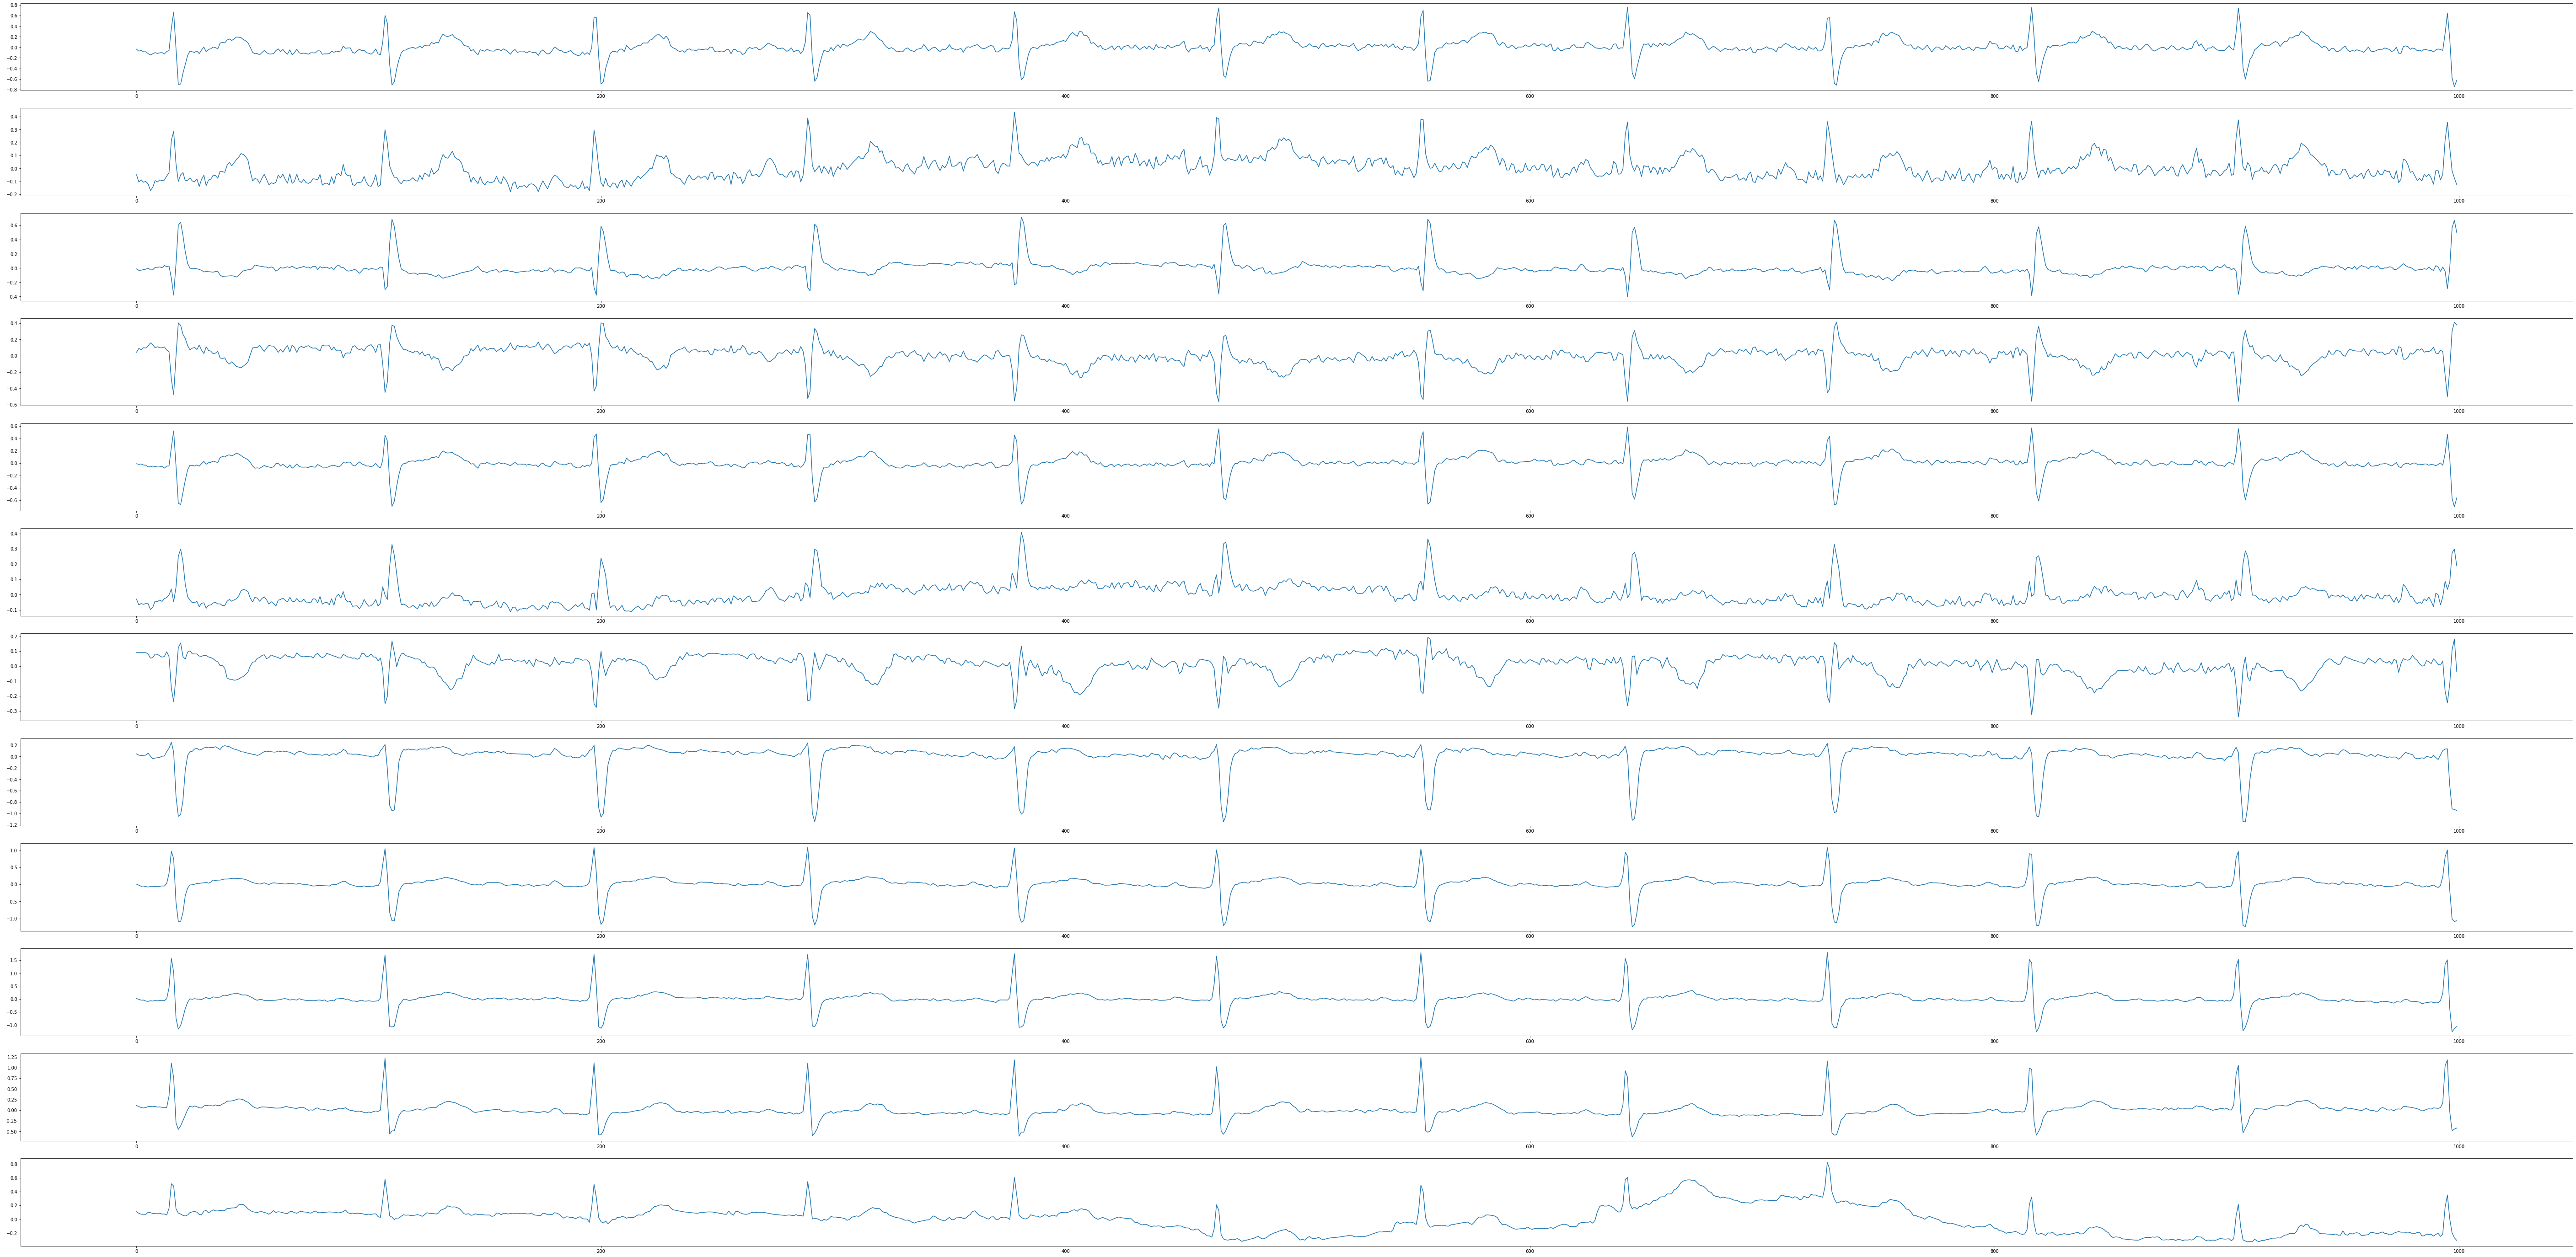

In [18]:
#18000번째 환자의 12-lead ECGs 파형 시각화한 것
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(100,50))
for i in range(12):
    plt.subplot(12, 1, i+1)
    plt.plot(X[18000,:,i])

In [19]:
test_fold = 10

# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].target

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].target

In [20]:
y_train

ecg_id
1        0
2        0
3        0
4        0
5        0
        ..
21833    0
21834    0
21835    0
21836    0
21837    0
Name: target, Length: 19634, dtype: int64

In [21]:
model = Sequential()

model.add(layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=1,
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Conv1D(filters=64,
                        kernel_size=5,
                        strides=1,
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Conv1D(filters=64,
                        kernel_size=5,
                        strides=1,
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Conv1D(filters=128,
                        kernel_size=5,
                        strides=1,
                        padding='valid',
                        activation='relu'))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Conv1D(filters=128,
                        kernel_size=5,
                        strides=1,
                        padding='valid',
                        activation='relu'))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Flatten())

model.add(layers.Dense(units=512,activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=1,activation='sigmoid'))

In [22]:
model.build(input_shape=(None,1000,12))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 32)          1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 333, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 333, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 333, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 111, 64)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 111, 64)           0

In [24]:
# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 30, mode='min')

In [26]:
hist = model.fit(X_train, y_train, 
                 epochs=200, 
                 batch_size = 50,
                 validation_split = 0.2, 
                 callbacks = [early_stop],
                 shuffle=True, 
                 verbose = 1)

Epoch 1/200
315/315 [==============================] - 51s 153ms/step - loss: 0.3491 - binary_accuracy: 0.8715 - val_loss: 0.3575 - val_binary_accuracy: 0.8220
Epoch 2/200
315/315 [==============================] - 47s 149ms/step - loss: 0.2988 - binary_accuracy: 0.8783 - val_loss: 0.3661 - val_binary_accuracy: 0.8133
Epoch 3/200
315/315 [==============================] - 47s 148ms/step - loss: 0.2670 - binary_accuracy: 0.8914 - val_loss: 0.4617 - val_binary_accuracy: 0.7673
Epoch 4/200
315/315 [==============================] - 47s 148ms/step - loss: 0.2547 - binary_accuracy: 0.8976 - val_loss: 0.3725 - val_binary_accuracy: 0.8271
Epoch 5/200
315/315 [==============================] - 47s 148ms/step - loss: 0.2437 - binary_accuracy: 0.8997 - val_loss: 0.4089 - val_binary_accuracy: 0.8098
Epoch 6/200
315/315 [==============================] - 47s 148ms/step - loss: 0.2370 - binary_accuracy: 0.9028 - val_loss: 0.3652 - val_binary_accuracy: 0.8314
Epoch 7/200
315/315 [===================

Epoch 52/200
315/315 [==============================] - 45s 144ms/step - loss: 0.1812 - binary_accuracy: 0.9235 - val_loss: 0.2502 - val_binary_accuracy: 0.8974
Epoch 53/200
315/315 [==============================] - 43s 136ms/step - loss: 0.1885 - binary_accuracy: 0.9219 - val_loss: 0.2512 - val_binary_accuracy: 0.9040
Epoch 54/200
315/315 [==============================] - 43s 137ms/step - loss: 0.1829 - binary_accuracy: 0.9249 - val_loss: 0.2749 - val_binary_accuracy: 0.8971
Epoch 55/200
315/315 [==============================] - 43s 137ms/step - loss: 0.1838 - binary_accuracy: 0.9215 - val_loss: 0.2418 - val_binary_accuracy: 0.9012
Epoch 56/200
315/315 [==============================] - 43s 135ms/step - loss: 0.1812 - binary_accuracy: 0.9258 - val_loss: 0.2762 - val_binary_accuracy: 0.8946
Epoch 57/200
315/315 [==============================] - 42s 135ms/step - loss: 0.1810 - binary_accuracy: 0.9237 - val_loss: 0.2560 - val_binary_accuracy: 0.9017
Epoch 58/200
315/315 [============

Epoch 103/200
315/315 [==============================] - 44s 140ms/step - loss: 0.1691 - binary_accuracy: 0.9300 - val_loss: 0.2376 - val_binary_accuracy: 0.9037
Epoch 104/200
315/315 [==============================] - 44s 140ms/step - loss: 0.1747 - binary_accuracy: 0.9296 - val_loss: 0.2492 - val_binary_accuracy: 0.9012
Epoch 105/200
315/315 [==============================] - 44s 139ms/step - loss: 0.1718 - binary_accuracy: 0.9303 - val_loss: 0.2320 - val_binary_accuracy: 0.9083
Epoch 106/200
315/315 [==============================] - 46s 147ms/step - loss: 0.1734 - binary_accuracy: 0.9285 - val_loss: 0.2357 - val_binary_accuracy: 0.9025
Epoch 107/200
315/315 [==============================] - 48s 151ms/step - loss: 0.1718 - binary_accuracy: 0.9300 - val_loss: 0.2363 - val_binary_accuracy: 0.9048
Epoch 108/200
315/315 [==============================] - 47s 150ms/step - loss: 0.1702 - binary_accuracy: 0.9293 - val_loss: 0.2507 - val_binary_accuracy: 0.9058
Epoch 109/200
315/315 [=====

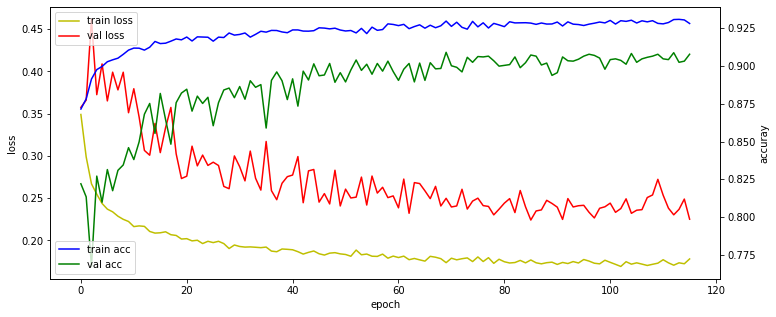

In [27]:
fig, loss_ax = plt.subplots(figsize=(12,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['binary_accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_binary_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [28]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('test_loss:', score[0])
print('test_acc:', score[1])

69/69 [==============================] - 2s 30ms/step - loss: 0.2065 - binary_accuracy: 0.9097
test_loss: 0.20646625757217407
test_acc: 0.9096686244010925
